In [2]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, box
from math import radians, sin, cos, sqrt, atan2, pi
from sklearn.preprocessing import MinMaxScaler

## Definitions of the main variables used

In [3]:
# Center location
center_location = "Frankfurt Hauptbahnhof, Germany"
#center_location = "Frankfurt-Höchst, Germany"

# Buffer the boundary by 2 km
radius_m = 2000

# Amenity types
amenity_type = {"amenity":['restaurant', 'cafe', 'bar']}
# Accessibility types
accessibility_type = {"public_transport":["platform", "station"]}
# Building Types
building_type = {"building":["residential", "office"]}

# Specify the search radius for computing the different requirements
radius_for_search = 200

## Functions to assist in retreiving the inital base location / working area

In [4]:
def get_location_point(location):    
    location_point = ox.geocoder.geocode(location)    
    return location_point

def get_features_from_point_within_radius(location_point, radius, tags):
    """Gets the different features within a radius of a specified point 

    Parameters
    ----------
    location_point : geometry
        The geometry of the location. 
    radius : int
        The search radius in meters. 
    tags : dict<list>
        The tags that define the features searh criteria. 

    Return
    ------
    features : dataframe
        The dataframe that contains all features within the radius of a specified point. 
    """
    bbox = ox.utils_geo.bbox_from_point(location_point, dist=radius, project_utm=False, return_crs=False)
    features = ox.features_from_bbox(bbox[0],bbox[1],bbox[2],bbox[3], tags=tags)    
    
    return features   


## Get the base location / working area

In [5]:
location_point = get_location_point(center_location)
df_amenities = get_features_from_point_within_radius(location_point=location_point, radius=radius_m, tags=amenity_type)
df_accessibility = get_features_from_point_within_radius(location_point=location_point, radius=radius_m, tags=accessibility_type)
df_building = get_features_from_point_within_radius(location_point=location_point, radius=radius_m, tags=building_type)
#df_amenities.head()
#df_accessibility.head()
#df_building.head()


## Functions to help with processing the data

In [6]:
def get_lat_long(geometry_val):    
    """Gets the latitude and longitude from the geometry value

    Parameters
    ----------
    geometry_val : geometry
        The geometry of the location. 

    Return
    ------
    lat : float
        The latitude value of the geometry. 
    lon : float
        The longitude value of the geometry. 
    """
    lat = 0
    lon = 0
    # Check if the geometry is a Point or Polygon
    if geometry_val.geom_type == 'Point':
        # Extract latitude and longitude from the point
        lat, lon = geometry_val.y, geometry_val.x
    elif geometry_val.geom_type == 'Polygon':
        # For polygons, use the centroid as a representative point            
        centroid_point = geometry_val.centroid
        # Extract the latitude and longitude of the centroid
        lat = centroid_point.y
        lon = centroid_point.x
    else:
        # Skip other geometry types
        return 0,0
    
    return lat, lon

def haversine_distance(lat1, lon1, lat2, lon2):
    """Using the Haversine formulat to get the distances between the two points

    Parameters
    ----------
    lat1 : float
        The latitude value of point 1. 
    lon1 : float
        The longitude value of point 1. 
    lat2 : float
        The latitude value of point 2. 
    lon2 : float
        The longitude value of point 2. 

    Return
    ------
    distance : float
        The distance between the two points in meters. 
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371000 * c  # Radius of Earth in meters (mean value)

    return distance

def density_count_points_within_radius(reference_point, radius, df, tag):
    """Gets the density and counts of the different features with the 
        radius of a given point. 

    Parameters
    ----------
    reference_point : geometry
        The geometry of the reference location. 
    radius : int
        The search radius in meters. 
    df : dataframe
        The dataframe containing the features to be analyzed. 
    tag : string
        The name of the feature being analyzed. 

    Return
    ------
    var : 
        The value cells of each of the count and density columns in the dataframe for that row. 
    """
    count = 0
    density = 0
    curr_lat, curr_lon = get_lat_long(reference_point)
    
    for _, row in df.iterrows():
        
        lat, lon = get_lat_long(row['geometry'])
        if((lat == 0) and (lon == 0)):
            continue
        distance = haversine_distance(curr_lat, curr_lon, lat, lon)
        
        if distance <= radius:
                count += 1
    
    density = (count / (pi * (radius ** 2)))
        
    return pd.Series({f"{tag}_count": count, f"{tag}_density_raw": density})

def calculate_score(row):
    """Calculates the score for each location based on the scoring formula.
        The scores can be further fine tuned by adjusting the weights of each feature. 

    Parameters
    ----------
    row : series
        The location to be scored. 

    Return
    ------
    score : float
        The score of the location. 
    """
    amenity_density = row['Amenities_density_raw']
    accessibility_density = row['Accessibility_density_raw']
    building_prox_density = row['Building_density_raw']

    # Customize scoring logic here
    score = 0.4 * amenity_density + 0.3 * accessibility_density+ 0.3 * building_prox_density

    return score

## Get the Amenity Density and Counts of each amenity location

In [7]:
amenity_dens_count_df = df_amenities.apply(
    lambda row: density_count_points_within_radius(row['geometry'], radius_for_search, df_amenities, "Amenities"), axis=1)
result_df = pd.merge(df_amenities, amenity_dens_count_df, left_index=True, right_index=True)
#amenity_dens_count_df.head()

## Get the Accessibility Counts of each amenity location

In [8]:
accessibility_count_df = df_amenities.apply(
    lambda row: density_count_points_within_radius(row['geometry'], radius_for_search, df_accessibility, "Accessibility"), axis=1)
result_df = pd.merge(result_df, accessibility_count_df, left_index=True, right_index=True)
#accessibility_count_df.head()

## Get the Bulding Proximity Counts of each amenity location

In [9]:
building_prox_count_df = df_amenities.apply(
    lambda row: density_count_points_within_radius(row['geometry'], radius_for_search, df_building, "Building"), axis=1)
result_df = pd.merge(result_df, building_prox_count_df, left_index=True, right_index=True)
#building_prox_count_df.head()


## Calculate the scores of each location

In [10]:
result_df['Score'] = result_df.apply(calculate_score, axis=1)
# Normalize the scores using Min-Max scaling
scaler = MinMaxScaler()
result_df['Normalized_Score'] = scaler.fit_transform(result_df[['Score']])

In [11]:
result_df.to_csv("Results.csv")
result_df.head()

amenity                name wheelchair  \
element_type osmid                                                  
node         264142632  restaurant  Pizzeria San Marco    limited   
             264143154  restaurant            Estragon        yes   
             264143268  restaurant           Marinella         no   
             265561618  restaurant              Rama V         no   
             265561658  restaurant          Curry Club    limited   

                                        geometry   contact:phone  \
element_type osmid                                                 
node         264142632  POINT (8.67587 50.12107)             NaN   
             264143154  POINT (8.68045 50.12021)  +49 69 5978038   
             264143268  POINT (8.68610 50.12023)   +49 69 558802   
             265561618  POINT (8.68645 50.11710)             NaN   
             265561658  POINT (8.68658 50.11690)             NaN   

                                                        opening_hours  \
element_type osmid                                                      
node         264142632                                            NaN   
             264143154                              Mo-Sa 18:00-24:00   
             264143268                                            NaN   
             265561618                                            NaN   
             265561658  Mo-Su 11:30-14:30,18:00-23:00; Sa 11:30-23:30   

                       toilets:wheelchair cuisine         old_name smoking  \
element_type osmid                                                           
node         264142632                NaN     NaN              NaN     NaN   
             264143154                 no     NaN              NaN     NaN   
             264143268                NaN     NaN              NaN     NaN   
             265561618                NaN    thai              NaN     NaN   
             265561658                 no  indian  Palace of India      no   

                        ... roof:shape leisure Amenities_count  \
element_type osmid      ...                                      
node         264142632  ...        NaN     NaN            10.0   
             264143154  ...        NaN     NaN            25.0   
             264143268  ...        NaN     NaN             4.0   
             265561618  ...        NaN     NaN            24.0   
             265561658  ...        NaN     NaN            26.0   

                       Amenities_density_raw Accessibility_count  \
element_type osmid                                                 
node         264142632              0.000080                 3.0   
             264143154              0.000199                 3.0   
             264143268              0.000032                 5.0   
             265561618              0.000191                 1.0   
             265561658              0.000207                 2.0   

                       Accessibility_density_raw Building_count  \
element_type osmid                                                
node         264142632                  0.000024            7.0   
             264143154                  0.000024            5.0   
             264143268                  0.000040            6.0   
             265561618                  0.000008            4.0   
             265561658                  0.000016            5.0   

                       Building_density_raw     Score Normalized_Score  
element_type osmid                                                      
node         264142632             0.000056  0.000056         0.224490  
             264143154             0.000040  0.000099         0.408163  
             264143268             0.000048  0.000039         0.153061  
             265561618             0.000032  0.000088         0.363946  
             265561658             0.000040  0.000099         0.411565  

[5 rows x 218 columns]

## Plot the results to their corresponding low, mid, and high scores

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
location_point = get_location_point(center_location)
bbox = ox.utils_geo.bbox_from_point(location_point, dist=2000, project_utm=False, return_crs=False)
graph = ox.graph_from_bbox(bbox[0],bbox[1],bbox[2],bbox[3], network_type='drive')

high_threshold = 0.8
low_threshold = 0.2

# Create separate dataframes for high, mid, and low scores
high_scores_df = result_df[result_df['Normalized_Score'] >= high_threshold]
mid_scores_df = result_df[(result_df['Normalized_Score'] < high_threshold) & (result_df['Normalized_Score'] >= low_threshold)]
low_scores_df = result_df[result_df['Normalized_Score'] < low_threshold]

<Axes: >

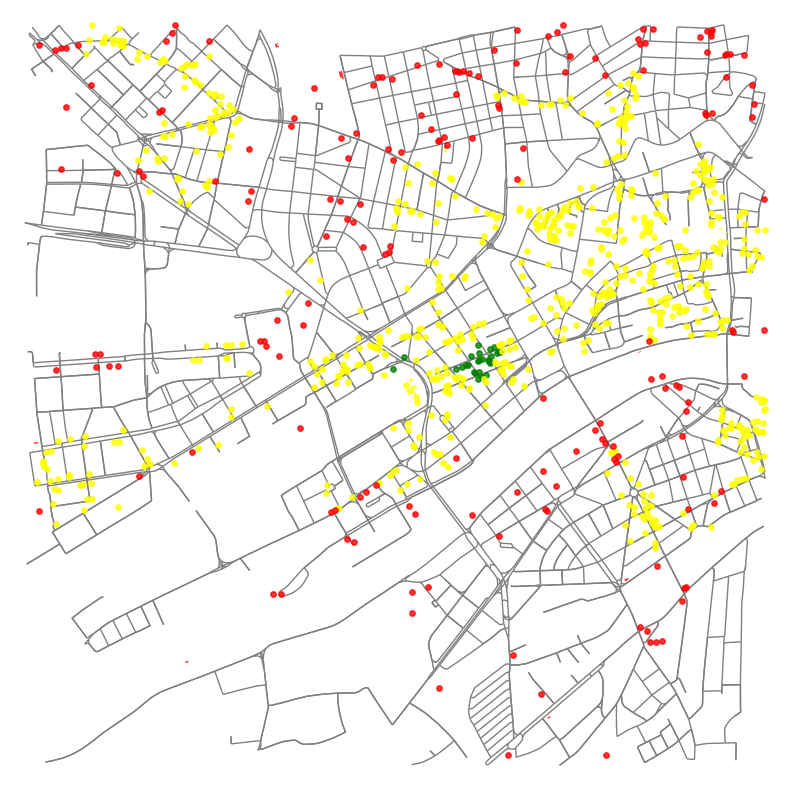

In [14]:

fig, ax = plt.subplots(figsize=(30, 10))
ox.plot_graph(graph, node_color='w', node_edgecolor='k', node_size=0, edge_color='gray', ax=ax, show=False)
high_scores_df.plot(ax=ax, markersize=15, color='green', alpha=0.8)
mid_scores_df.plot(ax=ax, markersize=15, color='yellow', alpha=0.8)
low_scores_df.plot(ax=ax, markersize=15, color='red', alpha=0.8)